In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image

## Table of Contents

* 1. Introduction
* 2. Metrics for imbalanced data
    * 2.1 Failure of Classification Accuracy for Imbalanced Class Distributions
    * 2.2 The most common metrics to use for imbalanced datasets
    * 2.3 Choosing metrics
* 3. Set-up
    * 3.1 Import Libraries
    * 3.2 Import Data
    * 3.3 Data Sets Characteristics
    * 3.4 Data imbalance check
    * 3.5 99,8% Accuracy score before implementing any model
* 4. Data pre-processing
    * 4.1 Dropping duplicated values
    * 4.2 Why we shouldn't delete outliers in this case
        * 4.2.1 Checking for outliers
        * 4.2.2 Inter Quartile Range (IQR)
        * 4.2.3 Conclusion - very important!
* 5. Train test split - you could have been splitting your dataset all wrong
    * 5.1 Stratified splitting
    * 5.2 Oversample/undersample before or after splitting data?
* 6. Feature scaling
* 7. Baseline (no oversampling)
    * 7.1 Cross-validation
    * 7.2 Stratified K-Fold CV (Cross-Validation)
    * 7.3 Oversample/undersample and Cross Validation
    * 7.4 Optimising for Recall
    * 7.5 When is Precision more important over Recall?
    * 7.6 Hyperparameter Tuning Using GridSearchCV
* 8. Random Resampling Imbalanced Datasets
    * 8.1 Random Oversampling
       * 8.1.1 Imbalanced-Learn Pipeline
       * 8.1.2 Training model
       * 8.1.3 GridSearchCV
       * 8.1.4 Confusion matrix and scores
    * 8.2 Random Undersampling Imbalanced Datasets
* 9. SMOTE (Synthetic Minority Oversampling Technique)
    * 9.1 Training model
    * 9.2 GridSearchCV
    * 9.3 Confusion matrix and scores
* 10. Undersampling using Tomek Links
* 11. Combining SMOTE and Tomek Links
    * 11.1 Training model
    * 11.2 GridSearchCV
    * 11.3 Confusion matrix and scores
* 12. Class weights in the models
    * 12.1 Training model
    * 12.2 GridSearchCV
    * 12.3 Confusion matrix and scores
* 13. Performance comparison
    * 13.1 Summary
* 14. Other Metrics
    * 14.1 AUC-ROC Curve
    * 14.2 Precision-Recall Curve (PR curve)
* 15. My other notebooks recommendations

# 1. Introduction

Imbalanced data refers to a situation, primarily in classification machine learning, where one target class represents a significant proportion of observations. Imbalanced datasets are those where there is a severe skew in the class distribution, such as 1:100 or 1:1000 examples in the minority class to the majority class.

Class Imbalance appear in many domains, including:

* Fraud detection (the vast majority of the transactions will be in the "Not-Fraud” class)
* Disease screening (the vast majority will be healthy)
* Subscription churn (the vast majority of customers stay with the service - the “No-Churn” class) 
* Ad Serving (click prediction datasets don’t have a high clickthrough rate)

There are several approaches to solving class imbalance problem before starting classification, such as:

* More samples from the minority class(es) should be acquired from the knowledge domain.

* Changing the loss function to give the failing minority class a higher cost.

* Oversampling the minority class.

* Undersampling the majority class.

* Any combination of previous approaches.

Oversampling methods duplicate or create new synthetic examples in the minority class, whereas undersampling methods delete or merge examples in the majority class. Oversampling is the most often used approach (but not necessarily the best).

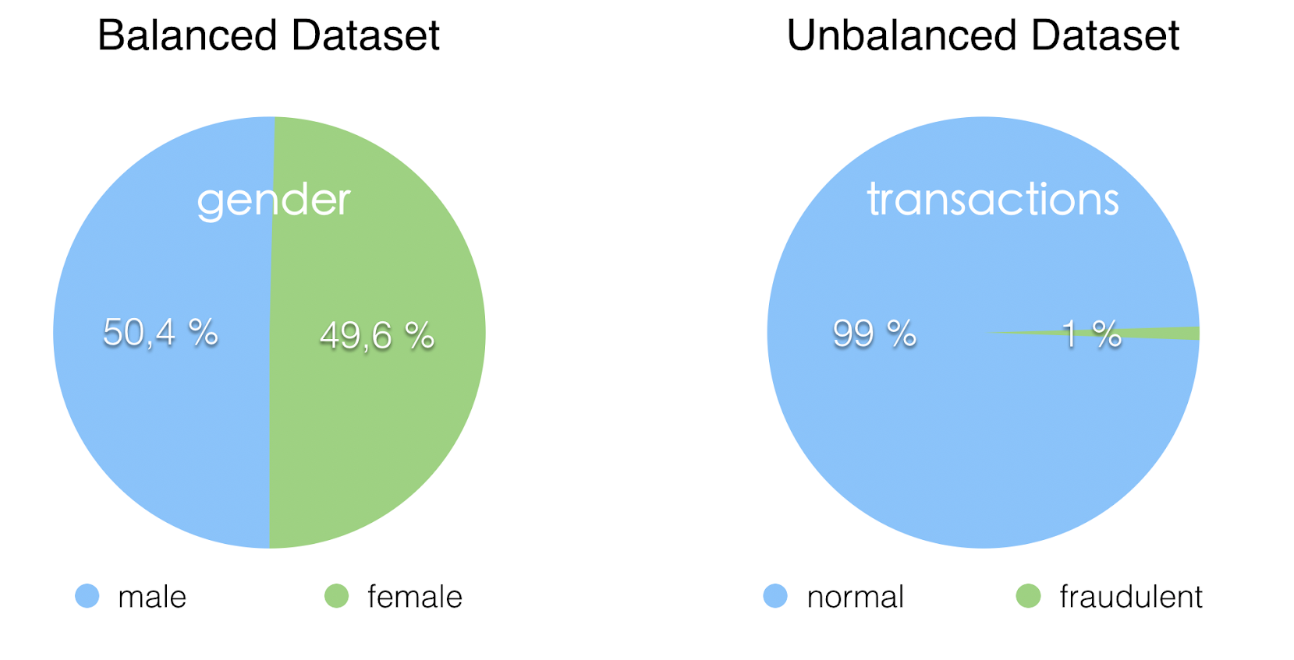

# 2. Metrics for imbalanced data

## 2. 1 Failure of Classification Accuracy for Imbalanced Class Distributions

Classification accuracy is a metric that summarizes the performance of a classification model as the number of correct predictions divided by the total number of predictions.

Accuracy = Correct Predictions / Total Predictions

Achieving 90 percent classification accuracy, or even 99 percent classification accuracy, may be trivial on an imbalanced classification problem. Consider the case of an imbalanced dataset with a 1:100 class imbalance. Blind guess will give us a 99% accuracy score (by betting on majority class).

The rule of thumb is: accuracy never helps in imbalanced dataset.

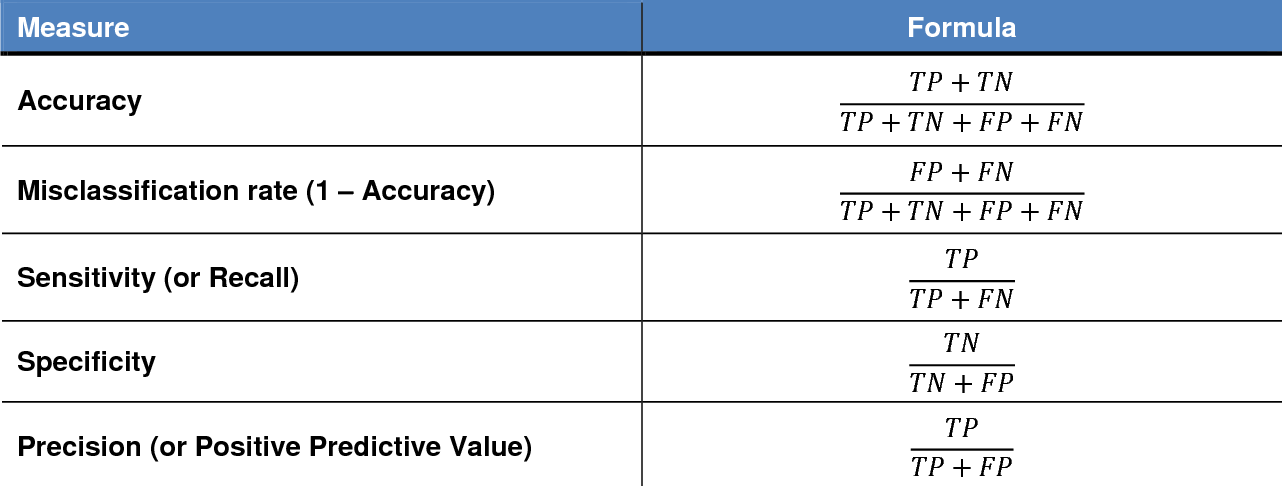

## 2.2 The most common metrics to use for imbalanced datasets

The most common metrics to use for imbalanced datasets are:

* F1 score
* Precision
* Recall
* AUC score (AUC ROC)
* Average precision score (AP)
* G-Mean

It is good practice to track multiple metrics when developing a machine learning model as each highlights different aspects of model performance. 

## 2.3 Choosing metrics

* Are you predicting probabilities?
    * Do you need class labels?
        * Is the positive class more important?
            * Use Precision-Recall AUC
        * Are both classes important?
            * Use ROC AUC
        * Do you need probabilities?
            * Use Brier Score and Brier Skill Score

* Are you predicting class labels?
    * Is the positive class more important?
        * Are False Negatives and False Positives Equally Important?
            * Use F1-Measure
        * Are False Negatives More Important?
            * Use F2-Measure
        * Are False Positives More Important?
            * Use F0.5-Measure
        * Are both classes important?
            * Do you have < 80%-90% Examples for the Majority Class? 
                * Use Accuracy
            * Do you have > 80%-90% Examples for the Majority Class? 
                * Use G-Mean
                
Source: https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

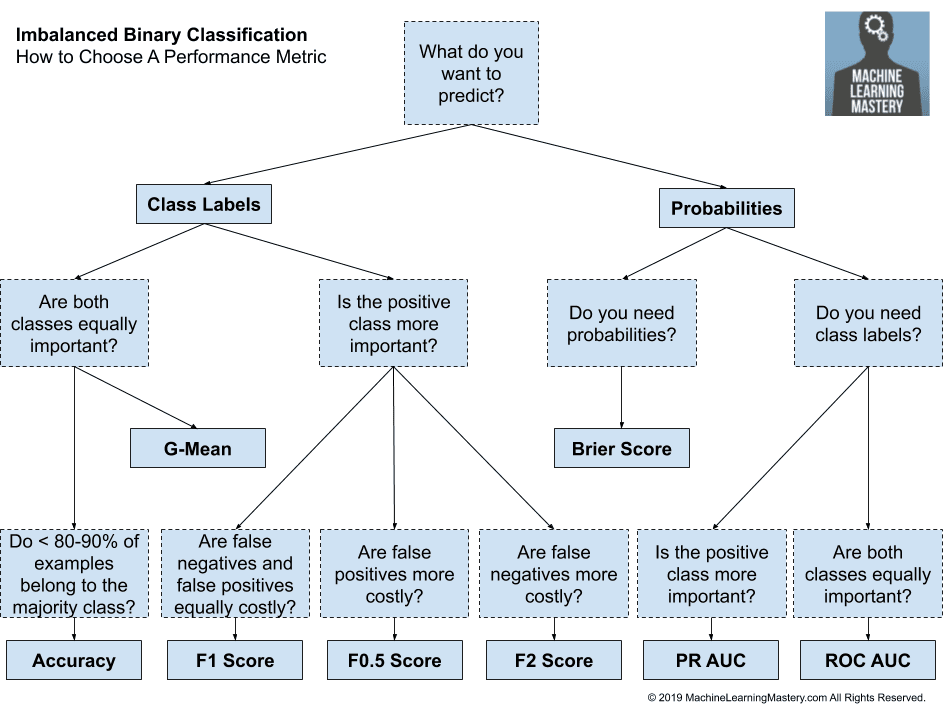

# 3. Set-up

## 3. 1 Import Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

## 3.2 Import Data

In [3]:
raw_df = pd.read_csv('./stats/dataClean v2.csv')

## 3.3 Data Set Characteristics

### Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

## 3.4 Data imbalance check

In [4]:
labels=["NoFall","Fall"]

fall_or_not = raw_df["fallsBin"].value_counts().tolist()
values = [fall_or_not[0], fall_or_not[1]]

fig = px.pie(values=raw_df['fallsBin'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fall vs No Fall Cases")
fig.show()

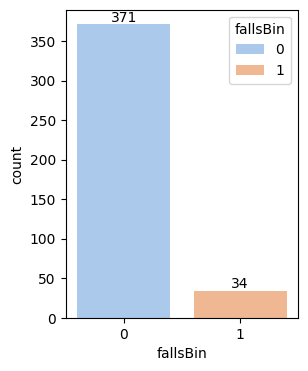

In [5]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='fallsBin',data=raw_df,palette="pastel", hue = 'fallsBin')
for i in ax.containers:
    ax.bar_label(i,)

## 3.5 99,8% Accuracy score before implementing any model

Don't use accuracy score as a metric with imbalanced datasets - it will be usually high and misleading. In this dataset:

* we have **99,8%** of Genuine transactions and only **0,173%** (492) of fraud transactions;

* whis means that a blind guess (bet on Genuine) would give us accuracy of **99,8%**.

# 4. Data pre-processing

The description of the data says that all the features went through a PCA transformation (Dimensionality Reduction technique) except for 'time' and 'Amount'.

For PCA features need to be previously scaled so we can assume that they are (except for 'time' and 'Amount').

## 4.1 Dropping duplicated values

In [6]:
df = raw_df.copy()

df.drop_duplicates(inplace=True)
print("Duplicated values dropped succesfully")
print("*" * 100)

Duplicated values dropped succesfully
****************************************************************************************************


## 4.2 Why we shouldn't delete outliers in this case

### 4.2.1 Checking for outliers

In [7]:
numeric_columns = list(df.iloc[:, :-1])
column_sets = [numeric_columns[i:i+20] for i in range(0, len(numeric_columns), 20)]
column_sets

[['time',
  'time_diff',
  'speed',
  'time_sd',
  'speed_sd',
  'left_knee_range_mean',
  'left_knee_sd',
  'left_knee_max',
  'left_knee_min',
  'left_knee_max_mean',
  'left_knee_min_mean',
  'left_knee_max_sd',
  'left_knee_min_sd',
  'left_knee_ang_vel',
  'left_knee_ang_acc',
  'left_knee_max_ang_vel',
  'left_knee_max_ang_acc',
  'left_knee_min_ang_vel',
  'left_knee_min_ang_acc',
  'right_knee_range_mean'],
 ['right_knee_sd',
  'right_knee_max',
  'right_knee_min',
  'right_knee_max_mean',
  'right_knee_min_mean',
  'right_knee_max_sd',
  'right_knee_min_sd',
  'right_knee_ang_vel',
  'right_knee_ang_acc',
  'right_knee_max_ang_vel',
  'right_knee_max_ang_acc',
  'right_knee_min_ang_vel',
  'right_knee_min_ang_acc',
  'left_hip_range_mean',
  'left_hip_sd',
  'left_hip_max',
  'left_hip_min',
  'left_hip_max_mean',
  'left_hip_min_mean',
  'left_hip_max_sd'],
 ['left_hip_min_sd',
  'left_hip_ang_vel',
  'left_hip_ang_acc',
  'left_hip_max_ang_vel',
  'left_hip_max_ang_acc',
  '

In [8]:
# checking boxplots
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,25))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        axs[i].set_xlabel('')

# for i in range(len(column_sets)-1):
#     boxplots_custom(dataset=df, columns_list=column_sets[i], rows=10, cols=2, suptitle='Boxplots for each variable')
#     plt.tight_layout()
#     plt.savefig(f'boxplots_{i}.png')
#     plt.close()

# boxplots_custom(dataset=df, columns_list=column_sets[-1], rows=3, cols=2, suptitle='Boxplots for each variable')
# plt.tight_layout()
# plt.savefig(f'boxplots_{len(column_sets)-1}.png')
# plt.close()

### 4.2.2 Inter Quartile Range (IQR)

We have a significant problems with outliers:

* huge outliers;

* higly skeved data;

* a lot of outliers.

Tukey’s (1977) technique is used to detect outliers in skewed or non bell-shaped data since it makes no distributional assumptions. However, Tukey’s method may not be appropriate for a small sample size. The general rule is that anything not in the range of (Q1 - 1.5 IQR) and (Q3 + 1.5 IQR) is an outlier, and can be removed.

Inter Quartile Range (IQR) is one of the most extensively used procedure for outlier detection and removal.

Procedure:

1. Find the first quartile, Q1.
2. Find the third quartile, Q3.
3. Calculate the IQR. IQR = Q3-Q1.
4. Define the normal data range with lower limit as Q1–1.5 IQR and upper limit as Q3+1.5 IQR.

For oulier detection methods look here: https://www.kaggle.com/code/marcinrutecki/outlier-detection-methods

In [9]:
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

In [10]:
# detecting outliers
Outliers_IQR = IQR_method(df,1,numeric_columns)

# dropping outliers
df_out = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 25


### 4.2.3 Conclusion - very important!

C:\Users\m93107ma\AppData\Local\Temp\ipykernel_13464\2699576693.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




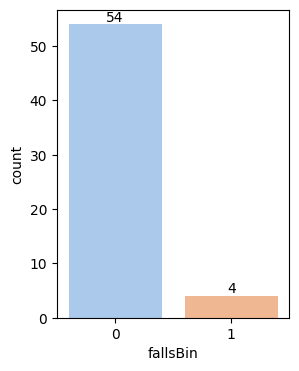

In [11]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='fallsBin',data=df_out,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

We stayed with only **26** fraud transactions in entire data frame!

#### We deleted almost all fraud transactions from a dataframe!

We have a few options here, but for that study we will just come back to the stage just before dropping outliers.

Very interesting option here is to create a new dataframe consisting only outliers. You can check the results of this approach here:

https://www.kaggle.com/code/marcinrutecki/credit-card-fraud-detection-tensorflow

# 5. Train test split - you could have been splitting your dataset all wrong

## 5.1 Stratified splitting

Stratified splitting means that when you generate a training / validation dataset split, it will attempt to keep the same percentages of classes in each split.

These dataset divisions are usually generated randomly according to a target variable. However, when doing so, the proportions of the target variable among the different splits can differ, especially in the case of small datasets.

In [12]:
X = df.drop('fallsBin', axis=1)
y = df['fallsBin']

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

## 5.2 Oversample/undersample before or after splitting data?

The rule of thumb is: **never mess up with your test set**. Always split into test and train sets BEFORE trying oversampling/undersampling techniques!

Oversampling before splitting the data can allow the exact same observations to be present in both the test and train sets. This can allow model to simply memorize specific data points and cause overfitting and poor generalization to the test data. Data leakage can cause you to create overly optimistic if not completely invalid predictive models.

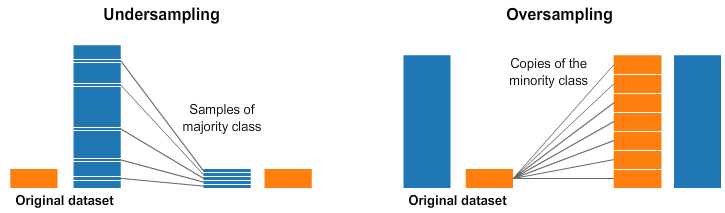

# 6. Feature scaling

In [15]:
from sklearn.preprocessing import StandardScaler

# Creating function for scaling
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    
    return df

In [16]:
col_names = X_train.columns
X_train = Standard_Scaler (X_train, col_names)
X_test = Standard_Scaler (X_test, col_names)

# 7. Baseline (no oversampling)

## 7.1 Cross-validation

The best model is not the one that gives accurate predictions on the training data, but the one which gives good predictions on the new data and avoids overfitting and underfitting.

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation.

The purpose of cross–validation is to test the ability of a machine learning model to predict new data. 

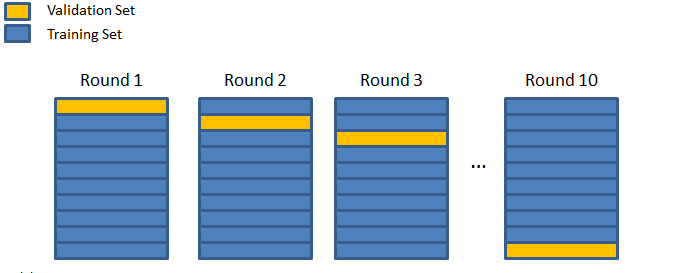

## 7.2 Stratified K-Fold CV (Cross-Validation)

Stratification is used when the datasets contain unbalanced classes. Therefore if we cross-validate with a normal technique it may produce subsamples that have a varying distribution of classes. Some unbalanced samples may produce exceptionally high scores leading to a high cross-validation score overall, which is undesirable. Therefore we create stratified subsamples that preserve the class frequencies in the individual folds to ensure that we are able to get a clear picture of the model performance.

## 7.3 Oversample/undersample and Cross Validation

If you want to undersample or oversample your data you shouldn't do it before cross validating because you will be directly influencing the validation set before implementing cross-validation causing a "data leakage" problem.

Exactly like we should do feature selection inside the cross validation loop, we should also oversample inside the loop.

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#We are going to ensure that we have the same splits of the data every time. 
#We can ensure this by creating a KFold object, kf, and passing cv=kf instead of the more common cv=5.

kf = StratifiedKFold(n_splits=5, shuffle=False)

In [18]:
# rf = RandomForestClassifier(n_estimators=100, random_state=13)
rf = LogisticRegression(max_iter=1000)
cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')

array([0.2 , 0.4 , 0.  , 0.25, 0.4 ])

## 7.4 Optimising for Recall

Recall: **The ability of a model to find all the relevant cases within a data set**. The number of true positives divided by the number of true positives plus the number of false negatives.

In most high-risk detection cases (like cancer), recall is a more important evaluation metric than precision.

In the case of credit card fraud detection, we want to avoid false negatives as much as possible. Fraud transactions cost us a lot and thus we want to take appropriate measures to prevent them. A false negative case means that a fraud-positive transaction is assessed to genuine transaction, which is detrimental. In this use case, false positives (a genuine transaction as fraud-positive) are not as important as preventing a fraud.

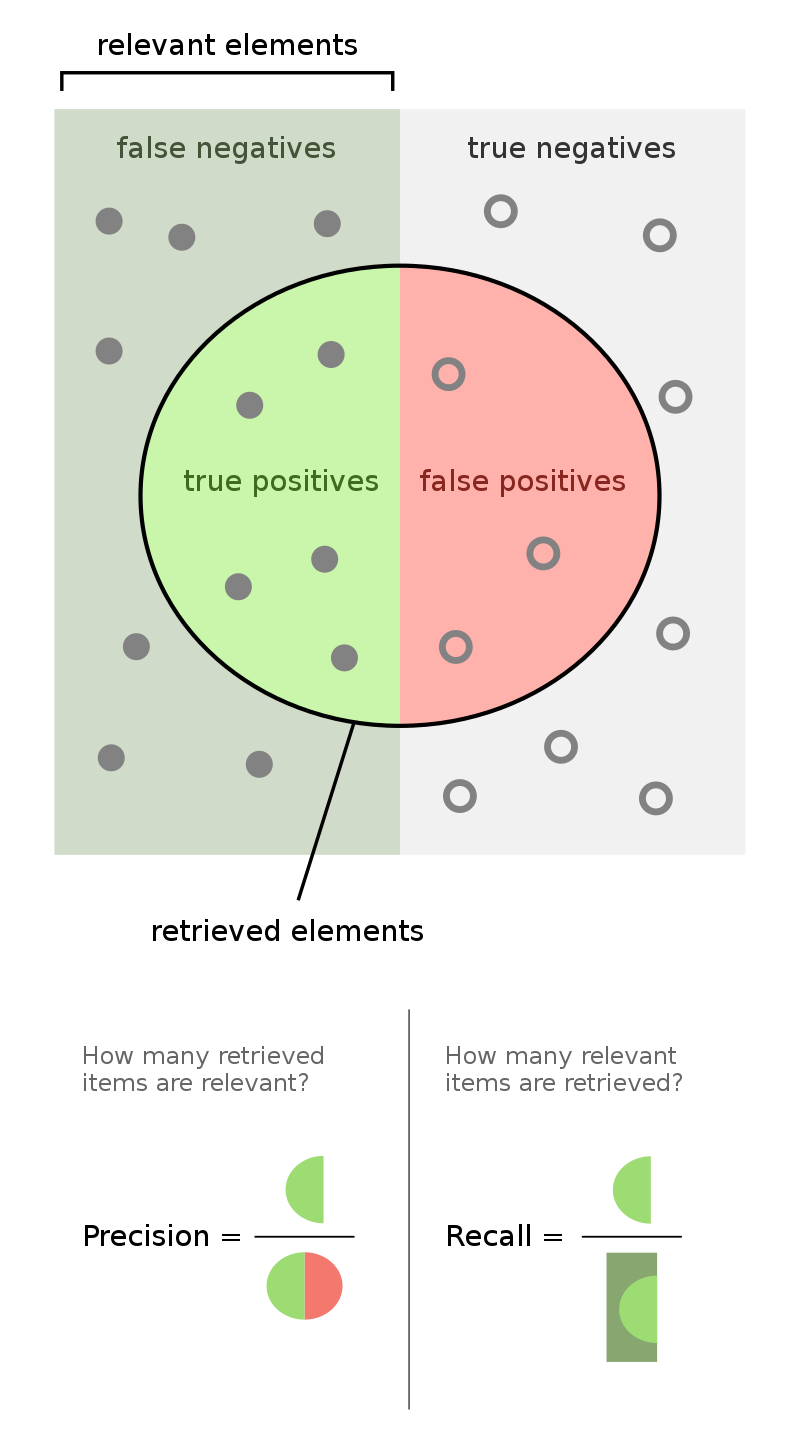

In [19]:
score = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall scores are: [0.2  0.4  0.   0.25 0.4 ]
Average Cross Validation Recall score: 0.25


## 7.5 When is Precision more important over Recall?

Precision is more important than Recall when you would like to have less False Positives in trade off to have more False Negatives. Meaning, getting a False Positive is very costly, and a False Negative is not as much.

Imagine a zombie apocalypse. You would try to accept as many healthy people as you can into your safe zone, but you really dont want to mistakenly pass a zombie. The true positive is this case is a healthy person and false positive a zombie. It is more important to avoid zombies than accepting more healthy people. So you create a method that causes some of the healthy people mistakenly not to get into the safe zone, but this is the cost of not letting a zombie in.

## 7.6 Hyperparameter Tuning Using GridSearchCV

Hyperparameter tuning is the process of tuning the parameters present as the tuples while we build machine learning models. These parameters are defined by us. Machine learning algorithms never learn these parameters. These can be tuned in different step.

GridSearchCV is a technique for finding the optimal hyperparameter values from a given set of parameters in a grid. It's essentially a cross-validation technique. The model as well as the parameters must be entered. After extracting the best parameter values, predictions are made.

The “best” parameters that GridSearchCV identifies are technically the best that could be produced, but only by the parameters that you included in your parameter grid.

In [20]:
# params = {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#     'C' : np.logspace(-4, 4, 20),
#     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
#     'max_iter' : [100, 1000,2500, 5000]
#     }

params = {'penalty' : ['l2'],
    'C' : np.logspace(-5, 2, 10),
    'solver' : ['liblinear'],
    'max_iter' : [1000]
    }

In [35]:
from sklearn.model_selection import GridSearchCV

# params = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [4, 6, 10, 12],
#     'random_state': [13]
# }


grid_rf = GridSearchCV(rf, param_grid=params, cv=kf, 
                          scoring='recall').fit(X_train, y_train)

In [59]:
print('Best parameters:', grid_rf.best_params_)
print('Best score:', grid_rf.best_score_)

Best parameters: {'C': 0.0001, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best score: 0.76


We have about 77% Recall on one of our models before oversampling. Let's check the test set scores.

In [60]:
y_pred = grid_rf.predict(X_test)

In [44]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
cm = confusion_matrix(y_test, y_pred)

rf_Recall = recall_score(y_test, y_pred)
rf_Precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[55 57]
 [ 3  7]]


In [67]:
ndf = [(rf_Recall, rf_Precision, rf_f1, rf_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Logistic Regression', 'No Under/Oversampling')
rf_score

,Logistic Regression,Recall,Precision,F1 Score,Accuracy
0,No Under/Oversampling,0.7,0.109375,0.189189,0.508197


The result Recall score for a test set is 77%. We will try to beat that score.

# 8. Random Resampling Imbalanced Datasets

Resampling involves creating a new transformed version of the training dataset in which the selected examples have a different class distribution.

There are two main approaches to random resampling for imbalanced classification; they are oversampling and undersampling.

* Random Oversampling: Randomly duplicate examples in the minority class.
* Random Undersampling: Randomly delete examples in the majority class.

They are referred to as “naive resampling” methods because they assume nothing about the data and no heuristics are used. This makes them simple to implement and fast to execute, which is **desirable for very large and complex datasets**.

#### Important
Change to the class distribution should be only applied to the **training dataset**. The intent is to influence the fit of the models. The resampling is not applied to the test or holdout dataset used to evaluate the performance of a model.

## 8.1 Random Oversampling

The random oversampling may increase the likelihood of occurring overfitting, since it makes exact copies of the minority class examples. Let's say every data point from the minority class is copied 6 times before making the splits. If we did a 3-fold validation, each fold has (on average) 2 copies of each point! In this way a classifier might construct rules that are apparently accurate, but actually cover one replicated example.

In [21]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
ros = RandomOverSampler(random_state=42)

In [22]:
# fit and apply the transform
X_over, y_over = ros.fit_resample(X_train, y_train)

In [23]:
print('No Falls:', y_over.value_counts()[0], '/', round(y_over.value_counts()[0]/len(y_over) * 100,2), '% of the dataset')
print('Falls:', y_over.value_counts()[1], '/',round(y_over.value_counts()[1]/len(y_over) * 100,2), '% of the dataset')

No Falls: 259 / 50.0 % of the dataset
Falls: 259 / 50.0 % of the dataset


<Axes: title={'center': 'Balanced dataset'}, xlabel='fallsBin'>

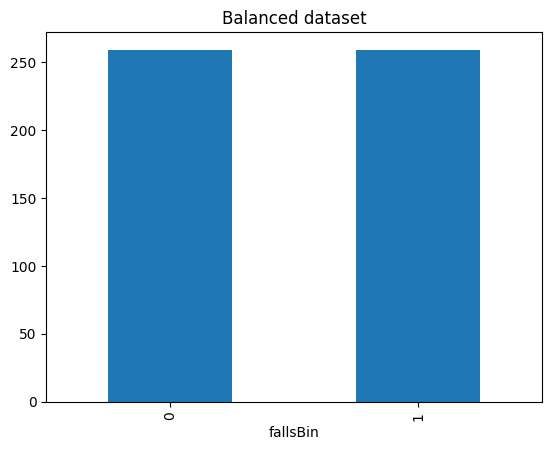

In [24]:
y_over.groupby(y_over).size().plot(kind='bar', title='Balanced dataset')

### 8.1.1 Imbalanced-Learn Pipeline

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.

During the cross-validation process we should split into training and validation segments. Then, on each segment, we should:

1. Oversample the minority class.
2. Train the classifier on the training segment.
3. Validate the classifier on the remaining segment.

Pipeline is a great way to do this in a smart way.

The imblearn package contains a lot of different samplers for oversampling and undersampling. These samplers can not be placed in a standard sklearn pipeline.

To allow for using a pipeline with these samplers, the imblearn package also implements an extended pipeline which has a bunch of extra functions to do with transforming and sampling.

### 8.1.2 Training model

In [25]:
from imblearn.pipeline import Pipeline, make_pipeline

random_overs_pipeline = make_pipeline(RandomOverSampler(random_state=42), 
                              LogisticRegression(C=0.0001, max_iter=100, penalty='l2', solver= 'liblinear'))
#cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)

In [26]:
score2 = cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score2))
print("Average Cross Validation Recall score: {}".format(score2.mean()))

Cross Validation Recall Scores are: [0.8 0.4 0.8 1.  1. ]
Average Cross Validation Recall score: 0.8


### 8.1.3 GridSearchCV

In [27]:
new_params = {'logisticregression__' + key: params[key] for key in params}

In [79]:

grid_over_rf = GridSearchCV(random_overs_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_over_rf.fit(X_train, y_train)

e:\PhD Work (Local)\Sit to Stand Fall Risk\sit2stand-fall\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

e:\PhD Work (Local)\Sit to Stand Fall Risk\sit2stand-fall\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

e:\PhD Work (Local)\Sit to Stand Fall Risk\sit2stand-fall\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

e:\PhD Work (Local)\Sit to Stand Fall Risk\sit2stand-fall\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

e:\PhD Work (Local)\Sit to Stand Fall Risk\sit2stand-fall\env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('randomoversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(C=0.0001,
                                                           solver='liblinear'))]),
             param_grid={'logisticregression__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03,...
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                         'logisticregression__max_iter': [100, 1000, 2500,
                                                          5000],
                         'logisticregression__penalty': ['l1', 'l2',
                                                         'elasticnet', 'none'],
                         'logisticregression__solver': ['lbfgs', 'newton-cg',
                                                        'liblinear', 'sag',
                                                        'saga']},
             return_train_score=True, scoring='recall')

In [80]:
print('Best parameters:', grid_over_rf.best_params_)
print('Best score:', grid_over_rf.best_score_)

Best parameters: {'logisticregression__C': 0.0001, 'logisticregression__max_iter': 100, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Best score: 0.8


### 8.1.4 Confusion matrix and scores

In [28]:
y_pred = grid_over_rf.best_estimator_.named_steps['logisticregression'].predict(X_test)

NameError: name 'grid_over_rf' is not defined

In [82]:
cm = confusion_matrix(y_test, y_pred)

over_rf_Recall = recall_score(y_test, y_pred)
over_rf_Precision = precision_score(y_test, y_pred)
over_rf_f1 = f1_score(y_test, y_pred)
over_rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[55 57]
 [ 5  5]]


In [69]:
ndf = [(over_rf_Recall, over_rf_Precision, over_rf_f1, over_rf_accuracy)]

over_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
over_rf_score.insert(0, 'Random Forest with', 'Random Oversampling')
over_rf_score

NameError: name 'over_rf_Recall' is not defined

## 8.2 Random Undersampling Imbalanced Datasets

Random undersampling involves randomly selecting examples from the majority class to delete from the training dataset. This approach may be more suitable for those datasets where there is a class imbalance although a sufficient number of examples in the minority class, such a useful model can be fit.

In [29]:
from imblearn.under_sampling import RandomUnderSampler
# define oversampling strategy
rus = RandomUnderSampler(random_state=42)

In [30]:
# fit and apply the transform
X_under, y_under = rus.fit_resample(X_train, y_train)

In [31]:
print('Genuine:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100,2), '% of the dataset')
print('Frauds:', y_under.value_counts()[1], '/',round(y_under.value_counts()[1]/len(y_under) * 100,2), '% of the dataset')

Genuine: 24 / 50.0 % of the dataset
Frauds: 24 / 50.0 % of the dataset


With our dataset after undersampling we have only 662 record so it's not the best idea to take advantage of that technique.

# 9. SMOTE (Synthetic Minority Oversampling Technique)

SMOTE (Synthetic Minority Oversampling Technique) synthesize elements for the minority class. SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

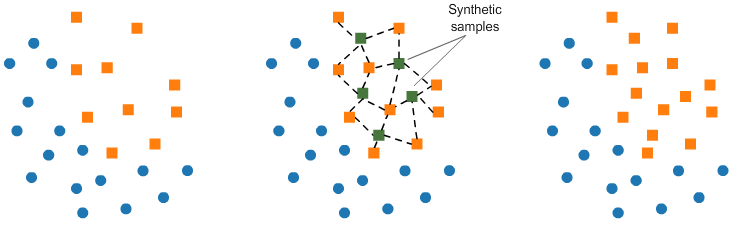

## 9.1 Training model

In [32]:
from imblearn.over_sampling import SMOTE

smote_pipeline = make_pipeline(SMOTE(random_state=42), 
                              LogisticRegression(C=0.0001, max_iter=100, penalty='l2', solver= 'liblinear'))
#cross_val_score(smote_pipeline, X_train, y_train, scoring='recall', cv=kf)

In [33]:
score3 = cross_val_score(smote_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score3))
print("Average Cross Validation Recall score: {}".format(score3.mean()))

Cross Validation Recall Scores are: [0.8 0.4 0.8 1.  1. ]
Average Cross Validation Recall score: 0.8


## 9.2 GridSearchCV

In [38]:
params = {'penalty' : ['l2'],
    'C' : np.logspace(-5, 2, 10),
    'solver' : ['liblinear'],
    'max_iter' : [1000]
    }

In [39]:
new_params = {'logisticregression__' + key: params[key] for key in params}
smote_rf = GridSearchCV(smote_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
smote_rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('logisticregression',
                                        LogisticRegression(C=0.0001,
                                                           solver='liblinear'))]),
             param_grid={'logisticregression__C': array([1.00000000e-05, 5.99484250e-05, 3.59381366e-04, 2.15443469e-03,
       1.29154967e-02, 7.74263683e-02, 4.64158883e-01, 2.78255940e+00,
       1.66810054e+01, 1.00000000e+02]),
                         'logisticregression__max_iter': [1000],
                         'logisticregression__penalty': ['l2'],
                         'logisticregression__solver': ['liblinear']},
             return_train_score=True, scoring='recall')

In [40]:
print('Best parameters:', smote_rf.best_params_)
print('Best score:', smote_rf.best_score_)

Best parameters: {'logisticregression__C': 1e-05, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
Best score: 0.8


## 9.3 Confusion matrix and scores

In [42]:
y_pred = smote_rf.best_estimator_.named_steps['logisticregression'].predict(X_test)

In [45]:
cm = confusion_matrix(y_test, y_pred)

smote_rf_Recall = recall_score(y_test, y_pred)
smote_rf_Precision = precision_score(y_test, y_pred)
smote_rf_f1 = f1_score(y_test, y_pred)
smote_rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[55 57]
 [ 3  7]]


In [70]:
ndf = [(smote_rf_Recall, smote_rf_Precision, smote_rf_f1, smote_rf_accuracy)]

smote_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
smote_rf_score.insert(0, 'Random Forest with', 'SMOTE Oversampling')
smote_rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,SMOTE Oversampling,0.7,0.109375,0.189189,0.508197


# 10. Undersampling using Tomek Links

Tomek Links is an under-sampling technique that was developed in 1976 by Ivan Tomek. It is one of a modification from Condensed Nearest Neighbors (CNN). It can be used to find desired samples of data from the majority class that is having the lowest Euclidean distance with the minority class data and then remove it.

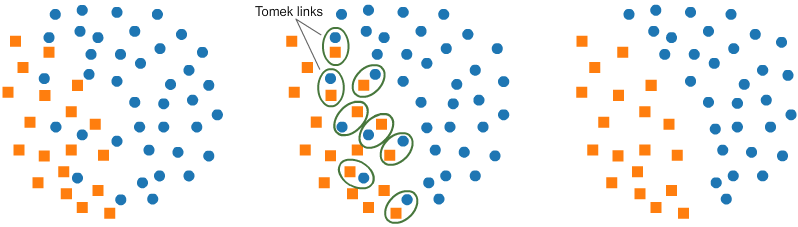

In [50]:
from imblearn.under_sampling import TomekLinks

# define the undersampling method
#tomekU = TomekLinks(sampling_strategy='auto', n_jobs=-1)
tomekU = TomekLinks()

# fit and apply the transform
X_underT, y_underT = tomekU.fit_resample(X_train, y_train)

In [51]:
print('No Falls:', y_underT.value_counts()[0], '/', round(y_underT.value_counts()[0]/len(y_underT) * 100,2), '% of the dataset')
print('Falls:', y_underT.value_counts()[1], '/',round(y_underT.value_counts()[1]/len(y_underT) * 100,2), '% of the dataset')

No Falls: 257 / 91.46 % of the dataset
Falls: 24 / 8.54 % of the dataset


# 11. Combining SMOTE and Tomek Links

A combination of over-sampling the minority (abnormal) class and under-sampling the majority (normal) class can achieve better classifier performance than only under-sampling the majority class. This method was first introduced by Batista et al. (2003).

The process of SMOTE-Tomek Links is as follows.

1. Start of SMOTE: choose random data from the minority class.
2. Calculate the distance between the random data and its k nearest neighbors.
3. Multiply the difference with a random number between 0 and 1, then add the result to the minority class as a synthetic sample.
4. Repeat step number 2–3 until the desired proportion of minority class is met (End of SMOTE).
5. Start of Tomek Links: choose random data from the majority class.
6. If the random data’s nearest neighbor is the data from the minority class (i.e. create the Tomek Link), then remove the Tomek Link.

## 11.1 Training model

In [55]:
from imblearn.combine import SMOTETomek

SMOTETomek_pipeline = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')), 
                              LogisticRegression(C=0.0001, max_iter=100, penalty='l2', solver= 'liblinear'))
#cross_val_score(smote_pipeline, X_train, y_train, scoring='recall', cv=kf)

score4 = cross_val_score(SMOTETomek_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score4))
print("Average Cross Validation Recall score: {}".format(score4.mean()))

## 11.2 GridSearchCV

GridSearchCV combined with SMOTE-Tomek and k-fold Cross-Validation is computationally very demanding. It takes more than 12 hours and that's impossible for Kaggle. That's why I did the computations on my local Yupyter Notebook and used best GridSearchCV parameters to fit the model.

You can find the formula for GridSearchCV below.

In [56]:
SMOTETomek_rf = SMOTETomek_pipeline
SMOTETomek_rf.fit(X_train, y_train)

Pipeline(steps=[('smotetomek',
                 SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))),
                ('logisticregression',
                 LogisticRegression(C=0.0001, solver='liblinear'))])

new_params = {'randomforestclassifier__' + key: params[key] for key in params}
SMOTETomek_rf = GridSearchCV(SMOTETomek_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
SMOTETomek_rf.fit(X_train, y_train)

## 11.3 Confusion matrix and scores

In [57]:
y_pred = SMOTETomek_rf.predict(X_test)

In [58]:
cm = confusion_matrix(y_test, y_pred)

SMOTETomek_rf_Recall = recall_score(y_test, y_pred)
SMOTETomek_rf_Precision = precision_score(y_test, y_pred)
SMOTETomek_rf_f1 = f1_score(y_test, y_pred)
SMOTETomek_rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[58 54]
 [ 4  6]]


In [59]:
ndf = [(SMOTETomek_rf_Recall, SMOTETomek_rf_Precision, SMOTETomek_rf_f1, SMOTETomek_rf_accuracy)]

SMOTETomek_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
SMOTETomek_rf_score.insert(0, 'Random Forest with', 'SMOTE + Tomek')
SMOTETomek_rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,SMOTE + Tomek,0.6,0.1,0.171429,0.52459


# 12. Class weights in the models

Most of the machine learning models provide a parameter called class_weights. For example, in a random forest classifier using, class_weights we can specify a higher weight for the minority class using a dictionary.

Without weights set, the model treats each point as equally important. Weights scale the loss function. As the model trains on each point, the error will be multiplied by the weight of the point. The estimator will try to minimize error on the more heavily weighted classes, because they will have a greater effect on error, sending a stronger signal.

## 12.1 Training model

In [60]:
# If you choose class_weight = "balanced", 
# the classes will be weighted inversely proportional to how frequently they appear in the data.

rfb = LogisticRegression(C=0.0001, max_iter=100, penalty='l2', solver= 'liblinear', class_weight="balanced")

In [61]:
score5 = cross_val_score(rfb, X_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score5))
print("Average Cross Validation Recall score: {}".format(score5.mean()))

Cross Validation Recall scores are: [0.8 0.4 0.6 1.  1. ]
Average Cross Validation Recall score: 0.76


## 12.2 GridSearchCV

In [62]:
grid_rfb = GridSearchCV(rfb, param_grid=params, cv=kf, 
                          scoring='recall').fit(X_train, y_train)

## 12.3 Confusion matrix and scores

In [63]:
y_pred = grid_rfb.predict(X_test)

In [64]:
cm = confusion_matrix(y_test, y_pred)

grid_rfb_Recall = recall_score(y_test, y_pred)
grid_rfb_Precision = precision_score(y_test, y_pred)
grid_rfb_f1 = f1_score(y_test, y_pred)
grid_rfb_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[58 54]
 [ 5  5]]


In [65]:
ndf = [(grid_rfb_Recall, grid_rfb_Precision, grid_rfb_f1, grid_rfb_accuracy)]

grid_rfb_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
grid_rfb_score.insert(0, 'Random Forest with', 'Class weights')
grid_rfb_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,Class weights,0.5,0.084746,0.144928,0.516393


# 13. Performance comparison

In [68]:
predictions = pd.concat([rf_score, over_rf_score, smote_rf_score, SMOTETomek_rf_score, grid_rfb_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

NameError: name 'over_rf_score' is not defined

## 13.1 Summary

* SMOTE Oversampling achived best Recall score, but it cost us a lot: Precision 0,25 and F1 Score: 0,39.
* The reference model without Under/Oversampling achived 0,77% Recall score.
* The most advanced model 'SMOTE and Tomek' wasn't the best in Recall score.
* Which model is the best? It depend on a business decision.

**Can we achive better results?**

Probably yes - there is much more to do when it comes to K-Fold Cross Validation and tuning hyperparameters. 

# 14. Other Metrics

## 14.1 AUC-ROC Curve

AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve.

ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

The ROC curve is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.

An excellent model has AUC near to the 1 which means it has a good measure of separability. A poor model has an AUC near 0 which means it has the worst measure of separability.

* When AUC is 0.7, it means there is a 70% chance that the model will be able to distinguish between positive class and negative class.
* When AUC is approximately 0.5, the model has no discrimination capacity to distinguish between positive class and negative class.
* When AUC is approximately 0, the model is predicting a negative class as a positive class and vice versa.

In [ ]:
from sklearn.metrics import roc_auc_score
ROCAUCscore = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Curve for Random Forest with Class weights: {ROCAUCscore:.4f}")

In [ ]:
y_proba = grid_rfb.predict_proba(X_test)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
# Plots the ROC curve using the sklearn methods - Good plot
plot_auc_roc_curve(y_test, y_proba[:, 1])
# Plots the ROC curve using the sklearn methods - Bad plot
#plot_sklearn_roc_curve(y_test, y_pred)

## 14.2 Precision-Recall Curve (PR curve)

The precision-recall curve shows the tradeoff between precision and recalls for different thresholds.

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    grid_rfb, X_test, y_test, name="Average precision")
_ = display.ax_.set_title("Random Forest with Class weights")

We can clearly see the point where we have to start trading a lot of Precision for better Recall score!

Average precision (AP) summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold.

# 15. My other notebooks

Regression Models Evaluation Metrics

https://www.kaggle.com/code/marcinrutecki/regression-models-evaluation-metrics

Clustering methods - comprehensive study

https://www.kaggle.com/code/marcinrutecki/clustering-methods-comprehensive-study

Outlier detection methods!

https://www.kaggle.com/code/marcinrutecki/outlier-detection-methods

Multicollinearity - detection and remedies

https://www.kaggle.com/code/marcinrutecki/multicollinearity-detection-and-remedies

# 16. Refferals

https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

https://towardsdatascience.com/stratified-sampling-you-may-have-been-splitting-your-dataset-all-wrong-8cfdd0d32502

https://ieeexplore.ieee.org/document/9761871

https://www.dominodatalab.com/blog/imbalanced-datasets

https://kiwidamien.github.io/how-to-do-cross-validation-when-upsampling-data.html

https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/

https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/

https://deepchecks.com/top-techniques-for-cross-validation-in-machine-learning/

https://www.vevesta.com/blog/30-SMOTE-Tomek-Links?utm_souce=Substack-Tomek-Links

https://towardsdatascience.com/imbalanced-classification-in-python-smote-tomek-links-method-6e48dfe69bbc

https://towardsdatascience.com/why-weight-the-importance-of-training-on-balanced-datasets-f1e54688e7df

https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

https://towardsai.net/p/l/precision-recall-curve